Our goal is to build a churn prediction model. To approach the problem, we will first conduct exploratory data analysis to understand the dataset, the nature of individual features, as well as relationships between features. This will give us insight on the performance metric we will use for model evaluation, as well as ideas on how to transform the features, what features to create and which features to include in the model.

We will then build a baseline model, which will be improved by resampling and feature selection methods. Thereafter, using a balanced dataset and the most optimal features, we will fit other models to find the best model and improve its performance by hyperparameter tuning. The most important features of the resulting model can then be identified and used to make recommendations to improve customer churn for the company. 

In [487]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from pylab import rcParams
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.feature_selection import chi2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

In [293]:
data = pd.read_csv('Data Exercise - Customer Churn.csv')

## Exploratory Data Analysis and Feature Engineering

### Exploring the dataset

In [294]:
data.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,2,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,4,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,5,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [295]:
data.dtypes

customerID            int64
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

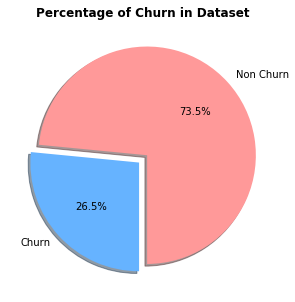

In [548]:
# Data to plot
sizes = data['Churn'].value_counts(sort = True)
explode = [0.05,0.05]               #len(x) array that specifies radius to separate wedge
labels = ["Non Churn","Churn"]
colors = ['#ff9999','#66b3ff'] 
rcParams['figure.figsize'] = 5,5
# Plot
plt.pie(sizes, explode = explode, labels = labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=270)
plt.title('Percentage of Churn in Dataset',weight = "bold", fontsize = "12", color = "black")
plt.show()

It appears that the dataset is unbalanced. The class for churn is only 26.5% of the total population of samples. There is a real risk that a model trained on this data may make too many predictions in favour of the majority class. To handle unbalanced classes, we can use a different performance metric instead of accuracy such as Area under ROC curve.

In [297]:
#dropping irrelevant data
data.drop(['customerID'], axis=1, inplace=True)

In [298]:
#Check for missing values
data.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

### Exploring Individual Features

In [299]:
#Visualize different values of variables
for col in data:
    print(data[col].value_counts(), '\n')

Male      3555
Female    3488
Name: gender, dtype: int64 

0    5901
1    1142
Name: SeniorCitizen, dtype: int64 

No     3641
Yes    3402
Name: Partner, dtype: int64 

No     4933
Yes    2110
Name: Dependents, dtype: int64 

1     613
72    362
2     238
3     200
4     176
71    170
5     133
7     131
8     123
70    119
9     119
12    117
10    116
6     110
13    109
68    100
15     99
11     99
67     98
18     97
69     95
24     94
22     90
66     89
35     88
17     87
23     85
64     80
56     80
16     80
     ... 
20     71
62     70
41     70
53     70
32     69
54     68
47     68
50     68
51     68
58     67
49     66
43     65
42     65
31     65
34     65
37     65
57     65
55     64
40     64
48     64
33     64
21     63
45     61
59     60
38     59
28     57
39     56
44     51
36     50
0      11
Name: tenure, Length: 73, dtype: int64 

Yes    6361
No      682
Name: PhoneService, dtype: int64 

No                  3390
Yes                 2971
No phone servi

For the categorical variables "gender", "Partner", "Dependents", "PhoneService", "MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "Contract", "PaperlessBilling", "PaymentMethod", we have to convert them to numeric form to be used in the models
- "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies" variables have a value called "No internet service", which might be a repetition of the "InternetService" variable. We have to decide whether to convert this value to "No" or keep it.
- "MultipleLines" seems to be a breakdown of the "PhoneService" variable, we might want explore the relationship between them and remove one if they are highly dependent.

For the numeric variables "tenure", "MonthlyCharges", "TotalCharges", we should visualize their distributions to see if there are any patterns in the data.

Firstly, we create 6 new variables where we convert "No Internet Service" to "No". We shall explore the relationships between variables later.

In [300]:
def noInternet(obs):                
    if obs == "No internet service":
        return "No"
    else:
        return obs
    
data["OnlineSecurity_Binary"] = data["OnlineSecurity"].apply(noInternet)
data["OnlineBackup_Binary"] = data["OnlineBackup"].apply(noInternet)
data["DeviceProtection_Binary"] = data["DeviceProtection"].apply(noInternet)
data["TechSupport_Binary"] = data["TechSupport"].apply(noInternet)
data["StreamingTV_Binary"] = data["StreamingTV"].apply(noInternet)
data["StreamingMovies_Binary"] = data["StreamingMovies"].apply(noInternet)

In [301]:
#Check if function is applied correctly
data["OnlineSecurity_Binary"].value_counts()

No     5024
Yes    2019
Name: OnlineSecurity_Binary, dtype: int64

Next, we shall visualize the distributions of the numeric variables to identify patterns.

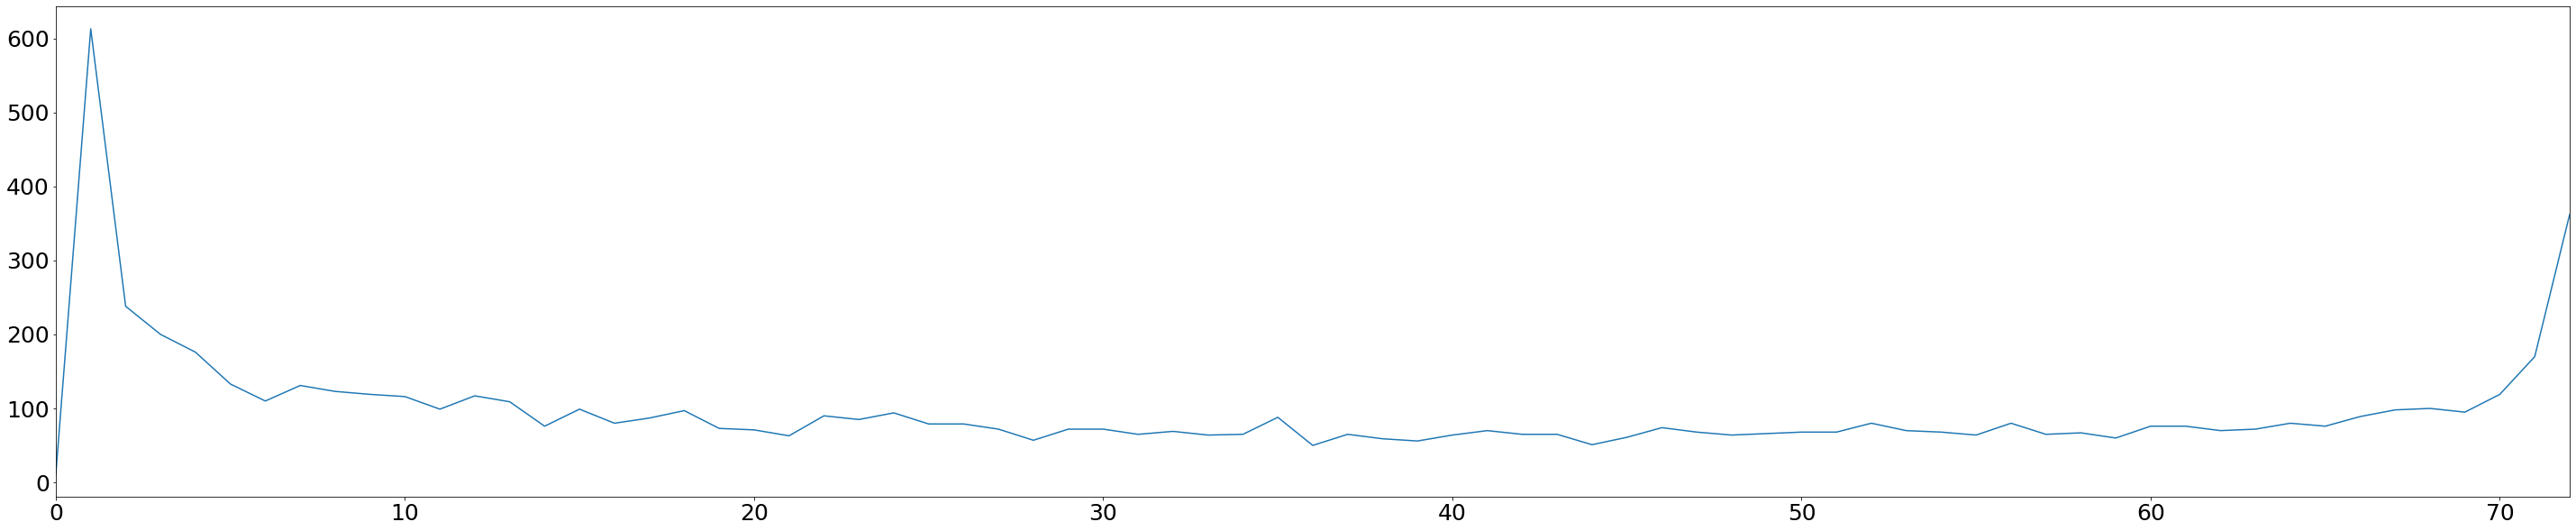

In [302]:
data["tenure"].value_counts().sort_index().plot(figsize=(50,10), fontsize = 25)

From plotting the "tenure" variable, it appears that many of the observations actually lie in the shortest and longest years, with a decreasing trend in shortest years and increasing trend in longest years. As such, it might be more representative to convert "tenure" into a categorical variable and split it into different buckets.

In [303]:
def assignBucket(data):                 
    if data["tenure"] <= 12:
        return "0 - 12"
    elif (data["tenure"] > 12) & (data["tenure"] <= 36):
        return "13 - 36"
    elif (data["tenure"] > 36) & (data["tenure"] <= 60):
        return "37 - 60"
    elif data["tenure"] > 60:
        return ">60" 
    
data["tenurebucket"] = data.apply(assignBucket, axis = 1)

In [573]:
data5 = pd.read_csv('Data Exercise - Customer Churn.csv')
data5["tenurebucket"] = data5.apply(assignBucket, axis = 1)

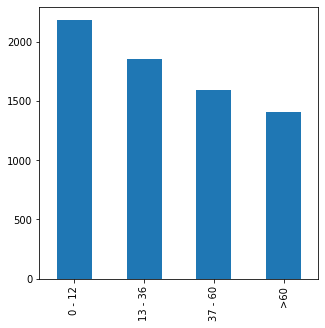

In [577]:
data5["tenurebucket"].value_counts().plot(kind="bar")

In [304]:
data["tenurebucket"].value_counts()

0 - 12     2186
13 - 36    1856
37 - 60    1594
>60        1407
Name: tenurebucket, dtype: int64

The buckets are chosen such that:
- the patterns in the shortest and longest years are captured
- each bucket has relatively equal number of observations

We can also plot the graphs of MonthlyCharges and TotalCharges to observe trends:

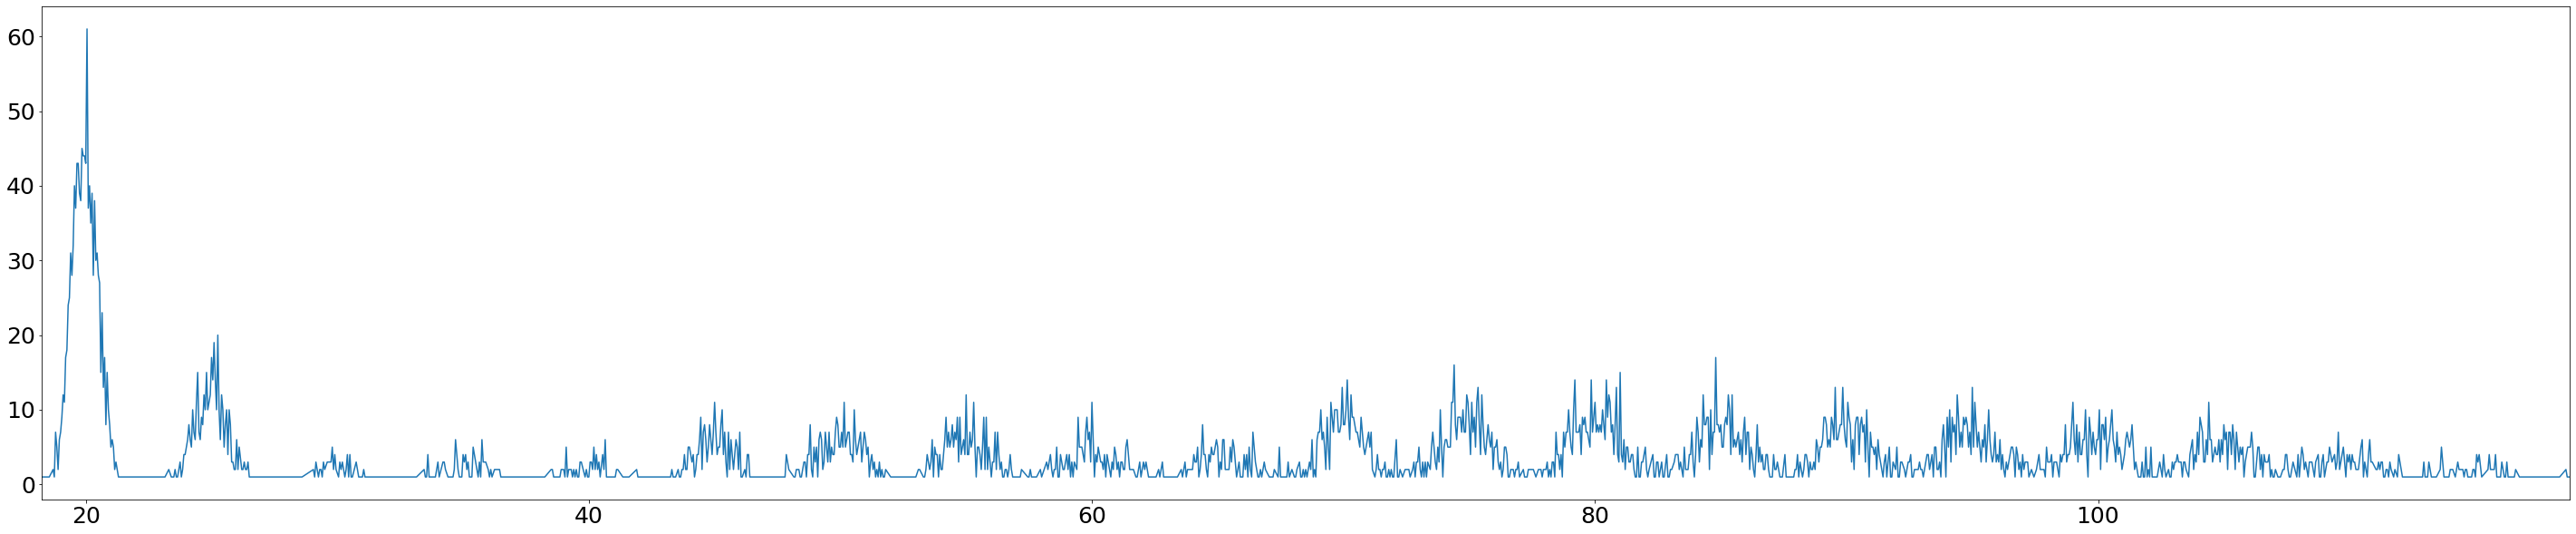

In [305]:
data["MonthlyCharges"].value_counts().sort_index().plot(figsize=(50,10), fontsize = 25)

In [306]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors = "coerce")

In [307]:
data['TotalCharges'].isnull().sum()

11

In [308]:
data = data.fillna(0)

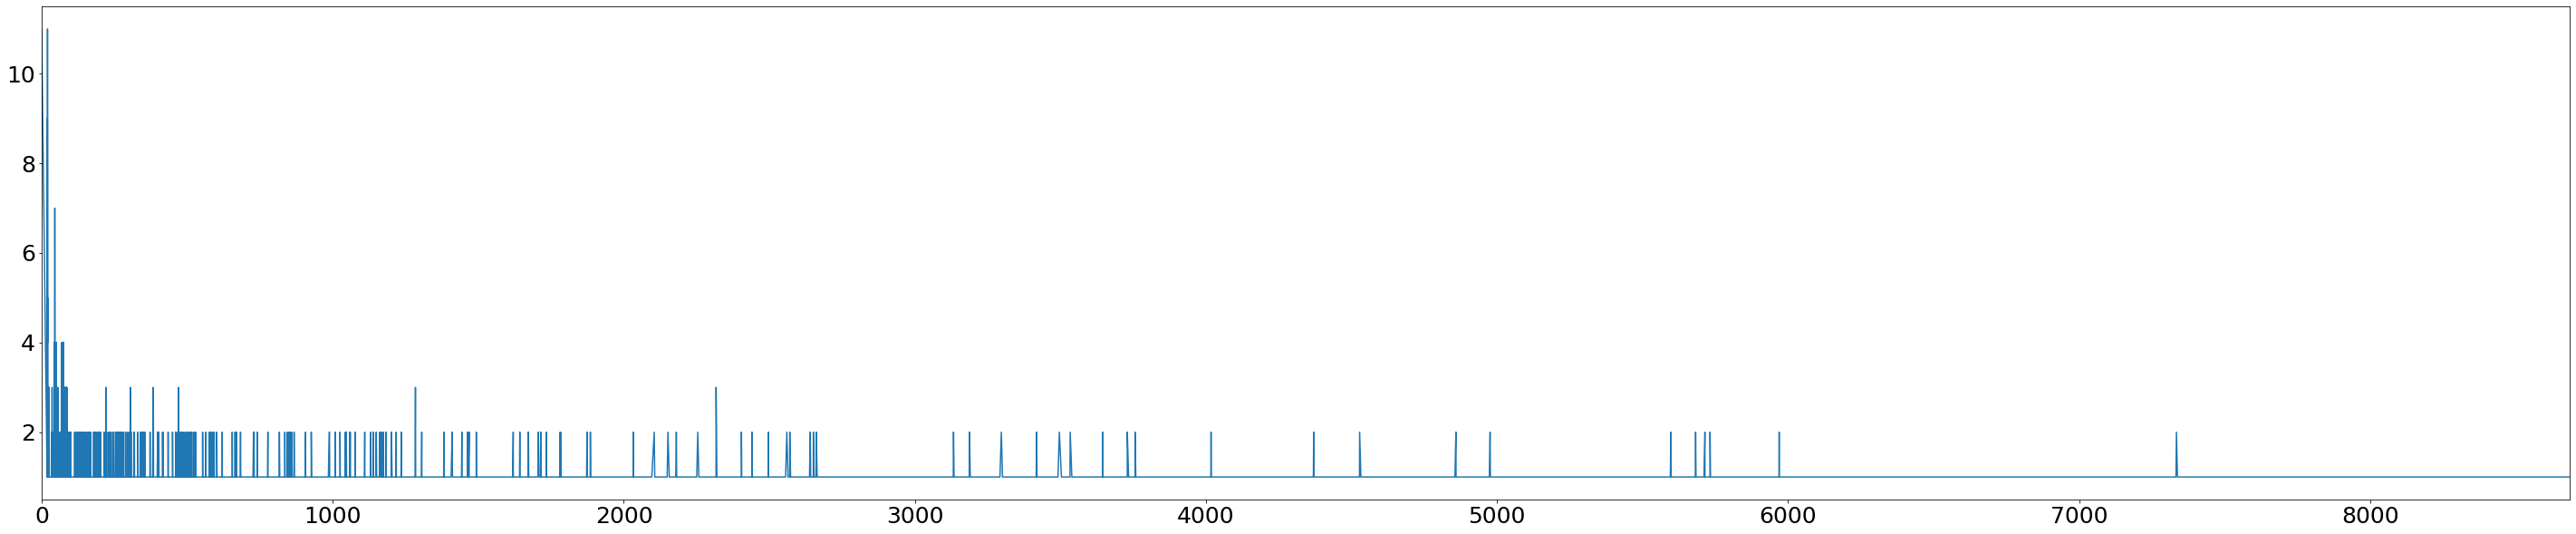

In [309]:
data["TotalCharges"].value_counts().sort_index().plot(figsize=(50,10), fontsize = 25)

Both graphs appear to have a similar pattern. Perhaps, MonthlyCharges and TotalCharges are highly correlated. We shall verify the relationship between the two variables later.

Last but not least, we shall label encode categorical variables to better assist us in further exploratory analysis such as finding the relationships between two variables. We use label encoding here, instead of one hot encoding, as the former allows us to perform exploratory analysis more quickly.

In [310]:
data['gender'].replace(['Female','Male'],[0,1],inplace=True)
data['Partner'].replace(['Yes','No'],[1,0],inplace=True)
data['Dependents'].replace(['Yes','No'],[1,0],inplace=True)
data['PhoneService'].replace(['Yes','No'],[1,0],inplace=True)
data['MultipleLines'].replace(['No phone service','No', 'Yes'],[2,0,1],inplace=True)
data['InternetService'].replace(['No','DSL','Fiber optic'],[0,1,2],inplace=True)
data['OnlineSecurity'].replace(['No','Yes','No internet service'],[0,1,2],inplace=True)
data['OnlineBackup'].replace(['No','Yes','No internet service'],[0,1,2],inplace=True)
data['DeviceProtection'].replace(['No','Yes','No internet service'],[0,1,2],inplace=True)
data['TechSupport'].replace(['No','Yes','No internet service'],[0,1,2],inplace=True)
data['StreamingTV'].replace(['No','Yes','No internet service'],[0,1,2],inplace=True)
data['StreamingMovies'].replace(['No','Yes','No internet service'],[0,1,2],inplace=True)
data['Contract'].replace(['Month-to-month', 'One year', 'Two year'],[0,1,2],inplace=True)
data['PaperlessBilling'].replace(['Yes','No'],[1,0],inplace=True)
data['PaymentMethod'].replace(['Electronic check', 'Mailed check', 'Bank transfer (automatic)','Credit card (automatic)'],[0,1,2,3],inplace=True)
data['OnlineSecurity_Binary'].replace(['No','Yes'],[0,1],inplace=True)
data['OnlineBackup_Binary'].replace(['No','Yes'],[0,1],inplace=True)
data['DeviceProtection_Binary'].replace(['No','Yes'],[0,1],inplace=True)
data['TechSupport_Binary'].replace(['No','Yes'],[0,1],inplace=True)
data['StreamingTV_Binary'].replace(['No','Yes'],[0,1],inplace=True)
data['StreamingMovies_Binary'].replace(['No','Yes'],[0,1],inplace=True)
data['Churn'].replace(['No','Yes'],[0,1],inplace=True)
data['tenurebucket'].replace(['0 - 12','13 - 36','37 - 60','>60'],[0,1,2,3],inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 27 columns):
gender                     7043 non-null int64
SeniorCitizen              7043 non-null int64
Partner                    7043 non-null int64
Dependents                 7043 non-null int64
tenure                     7043 non-null int64
PhoneService               7043 non-null int64
MultipleLines              7043 non-null int64
InternetService            7043 non-null int64
OnlineSecurity             7043 non-null int64
OnlineBackup               7043 non-null int64
DeviceProtection           7043 non-null int64
TechSupport                7043 non-null int64
StreamingTV                7043 non-null int64
StreamingMovies            7043 non-null int64
Contract                   7043 non-null int64
PaperlessBilling           7043 non-null int64
PaymentMethod              7043 non-null int64
MonthlyCharges             7043 non-null float64
TotalCharges               7043 non-null floa

### Exploring Feature Relations

Before proceeding to build the model, we want to explore relationships between similar variables to decide which features to keep in the model. To compare numeric variables, we shall employ the use of Pearson correlation. To compare categorical variables, we shall use the Chi squared test.

In particular, we want to find out relationships between the following variables:
- MonthlyCharges and TotalCharges 
- PhoneService and MultipleLines and Churn   
- InternetService and Online Services (eg. OnlineSecurity, OnlineBackup) and Churn 
- tenure and tenurebucket and Churn

If two features are highly correlated/dependent with each other, we shall remove one as they have similar representations.

If one feature is more dependent with the Target Variable than another feature, and both are similar features, we shall pick the feature that is more dependent.

0.651173831578784

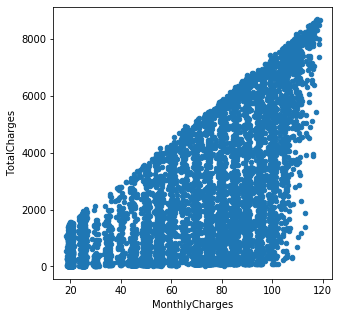

In [311]:
data.plot.scatter(x='MonthlyCharges',  y='TotalCharges')
data['MonthlyCharges'].corr(data['TotalCharges'], method='pearson')

It appears that MonthlyCharges is highly correlated with TotalCharges. As they both have the same representation and MonthlyCharges is more granular, we shall only use MonthlyCharges in our model.

In [312]:
print("Relationship between PhoneService and MultipleLines")

chi_scores = chi2(data["PhoneService"].values.reshape(-1, 1),data["MultipleLines"].values.reshape(-1, 1))
print("p-value: " + str(chi_scores[1][0]))

print("\n")
print("Relationship between PhoneService and Churn")

chi_scores1 = chi2(data["PhoneService"].values.reshape(-1, 1),data["Churn"].values.reshape(-1, 1))
print("p-value: " + str(chi_scores1[1][0]))

print("\n")
print("Relationship between MultipleLines and Churn")

chi_scores2 = chi2(data["MultipleLines"].values.reshape(-1, 1),data["Churn"].values.reshape(-1, 1))
print("p-value: " + str(chi_scores2[1][0]))

Relationship between PhoneService and MultipleLines
p-value: 8.04603043473803e-149


Relationship between PhoneService and Churn
p-value: 0.7551420910554429


Relationship between MultipleLines and Churn
p-value: 0.17290077097848633


p-value < 0.05 means that the two variables are dependent. As such, it appears that PhoneService and MultipleLines are dependent, meaning that one of the vars can be excluded from the model. 

While both variables appear to be independent from the target variable Churn, MultipleLines appears to be relatively less independent. Thus, we shall include MultipleLines and exclude PhoneService from the model later.

In [313]:
OnlineService_columns = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "OnlineSecurity_Binary", "OnlineBackup_Binary", "DeviceProtection_Binary", "TechSupport_Binary", "StreamingTV_Binary", "StreamingMovies_Binary"]

print("Relationship between Online Service vars and InternetService")
for i in OnlineService_columns:
    print(i)
    chi_scores3 = chi2(data[i].values.reshape(-1, 1),data["InternetService"].values.reshape(-1, 1))
    print("p-value: " + str(chi_scores3[1][0]))

print("\n")
print("Relationship between Online Service vars and Churn")
for i in OnlineService_columns:
    print(i)
    chi_scores4 = chi2(data[i].values.reshape(-1, 1),data["Churn"].values.reshape(-1, 1))
    print("p-value: " + str(chi_scores4[1][0]))

Relationship between Online Service vars and InternetService
OnlineSecurity
p-value: 0.0
OnlineBackup
p-value: 0.0
DeviceProtection
p-value: 0.0
TechSupport
p-value: 0.0
StreamingTV
p-value: 0.0
StreamingMovies
p-value: 0.0
OnlineSecurity_Binary
p-value: 3.444205239258328e-170
OnlineBackup_Binary
p-value: 8.322581468137909e-147
DeviceProtection_Binary
p-value: 3.3544618672127414e-146
TechSupport_Binary
p-value: 5.404771132584284e-167
StreamingTV_Binary
p-value: 1.734304939380516e-185
StreamingMovies_Binary
p-value: 2.2372477093724352e-184


Relationship between Online Service vars and Churn
OnlineSecurity
p-value: 1.236533742573607e-151
OnlineBackup
p-value: 2.621745388846261e-103
DeviceProtection
p-value: 1.0910011399461765e-96
TechSupport
p-value: 6.780536258993662e-148
StreamingTV
p-value: 4.227333807688429e-48
StreamingMovies
p-value: 2.1245032952018517e-48
OnlineSecurity_Binary
p-value: 6.761695980000446e-34
OnlineBackup_Binary
p-value: 2.306541235954759e-08
DeviceProtection_Binar

*Online Service variables before processing: "Yes", "No", "No internet service"

*Online Service variables after processing/ Binary Variables: "Yes", "No"

It appears that the Online Service variables, before and after processing, are dependent with InternetService and Churn. However, Online Service variables before processing are more dependent with InternetService, meaning that they have very similar representations with InternetService. As such, to allow for some variation, we will keep Online Service variables after processing (binary Online Service variables) in the model. 

In [314]:
print("Relationship between tenure and tenurebucket")

chi_scores5 = chi2(data["tenure"].values.reshape(-1, 1),data["tenurebucket"].values.reshape(-1, 1))
print("p-value: " + str(chi_scores5[1][0]))

print("\n")
print("Relationship between tenure and Churn")

chi_scores6 = chi2(data["tenure"].values.reshape(-1, 1),data["Churn"].values.reshape(-1, 1))
print("p-value: " + str(chi_scores6[1][0]))

print("\n")
print("Relationship between tenurebucket and Churn")

chi_scores7 = chi2(data["tenurebucket"].values.reshape(-1, 1),data["Churn"].values.reshape(-1, 1))
print("p-value: " + str(chi_scores7[1][0]))

Relationship between tenure and tenurebucket
p-value: 0.0


Relationship between tenure and Churn
p-value: 0.0


Relationship between tenurebucket and Churn
p-value: 1.9588816927683162e-168


As tenurebucket was derived from tenure, both variables are very dependent with each other. However, tenure is more dependent with Churn than tenurebucket. Thus, we will include tenure and exclude tenurebucket in the model.

In essence, we will exclude TotalCharges, PhoneService, Online Service variables before processing and tenurebucket from our features. We shall also prepare the dataset for modeling by doing a train test split. A test size of 0.3 is chosen, as opposed to the standard 0.2, since the dataset is relatively small (<10,000 observations) and this reduces overfitting.

In [315]:
data.drop(["TotalCharges","PhoneService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "tenurebucket"], axis=1, inplace=True)

train, test = train_test_split(data, test_size = 0.3)
 
train_y = train['Churn']
test_y = test['Churn']
 
train_x = train
train_x.pop('Churn')
test_x = test
test_x.pop('Churn')

4047    0
1890    1
4450    1
6790    0
4526    0
1302    0
1169    0
635     1
998     0
909     0
6938    0
4473    0
6104    0
801     1
2198    0
5918    0
1356    0
202     0
856     0
85      0
6771    0
1112    0
4251    0
587     0
1461    0
5624    0
5939    0
1404    0
4757    1
3504    0
       ..
6763    0
7028    0
3475    0
1510    0
398     0
6570    0
1472    1
1497    0
823     0
4268    0
386     1
2656    0
3319    1
2637    0
3633    0
2437    0
203     0
6211    1
2440    0
3227    0
4206    0
223     1
6989    0
3424    1
4458    1
858     0
5811    0
3589    0
4578    0
4839    1
Name: Churn, Length: 2113, dtype: int64

## Model Building and Feature Selection

### Baseline Model

Intercept: [-1.52032216]
Regression: [[-0.09648494  0.29022473  0.0346636  -0.21802567 -0.03443476  0.34538261
   0.73542973 -0.60217709  0.3824415  -0.14122726  0.00698259 -0.53366597
  -0.2083381  -0.05570161 -0.34947446  0.2545845   0.20616776]]
Accuracy of logistic regression classifier on test set: 0.80
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1542
           1       0.65      0.52      0.58       571

    accuracy                           0.80      2113
   macro avg       0.75      0.71      0.72      2113
weighted avg       0.79      0.80      0.79      2113



Text(0.5, 24.0, 'Predicted label')

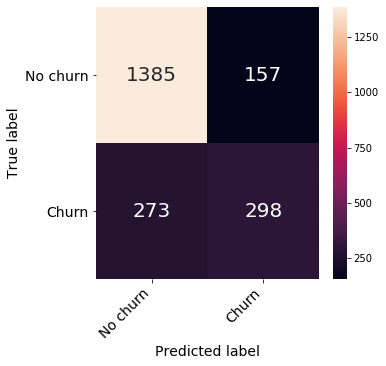

In [316]:
logisticRegr = LogisticRegression()
logisticRegr.fit(X=train_x, y=train_y)
 
test_y_pred = logisticRegr.predict(test_x)
confusion_matrix = confusion_matrix(test_y, test_y_pred)
print('Intercept: ' + str(logisticRegr.intercept_))
print('Regression: ' + str(logisticRegr.coef_))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logisticRegr.score(test_x, test_y)))
print(classification_report(test_y, test_y_pred))

confusion_matrix_df = pd.DataFrame(confusion_matrix, ('No churn', 'Churn'), ('No churn', 'Churn'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)

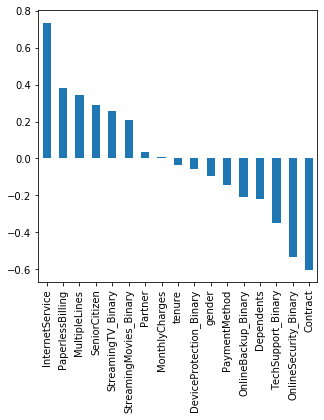

In [317]:
# To get the weights/coefficients of all the variables, and display feature importance
# the higher the value, the more important or relevant the feature towards the output variable   
weights2 = pd.Series(logisticRegr.coef_[0],
 index=test_x.columns.values)
weights2.sort_values(ascending = False).plot(kind = "bar")

In [318]:
# Get class probabilities for model
test_y_prob = logisticRegr.predict_proba(test_x)
 
# We only need the probabilities for the positive class
test_y_prob = [p[1] for p in test_y_prob]
 
print('Unbalanced model AUROC: ' + str(roc_auc_score(test_y, test_y_prob)))

Unbalanced model AUROC: 0.8387400310284594


### Resampling with Replacement

To improve performance of the baseline model, we can consider doing resampling with replacement. In this case, we will upsample the minority class to match the number of observations in the majority class.

In [319]:
#resampling with replacement:
data_majority = data[data['Churn']==0]
data_minority = data[data['Churn']==1]
 
data_minority_upsampled = resample(data_minority,
replace=True,
n_samples=5174,   #same number of samples as majority class
random_state=1)   #set the seed for random resampling

# Combine resampled results
data_upsampled = pd.concat([data_majority, data_minority_upsampled])
data_upsampled['Churn'].value_counts()

1    5174
0    5174
Name: Churn, dtype: int64

In [320]:
#now that we have ratio of 1:1, let's build another logreg model

train, test = train_test_split(data_upsampled, test_size = 0.3)
 
train_y_upsampled = train['Churn']
test_y_upsampled = test['Churn']
 
train_x_upsampled = train
train_x_upsampled.pop('Churn')
test_x_upsampled = test
test_x_upsampled.pop('Churn')
 
logisticRegr_balanced = LogisticRegression()
logisticRegr_balanced.fit(X=train_x_upsampled, y=train_y_upsampled)
 
test_y_pred_balanced = logisticRegr_balanced.predict(test_x_upsampled)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logisticRegr_balanced.score(test_x_upsampled, test_y_upsampled)))
print(classification_report(test_y_upsampled, test_y_pred_balanced))

Accuracy of logistic regression classifier on test set: 0.77
              precision    recall  f1-score   support

           0       0.77      0.76      0.76      1270
           1       0.77      0.78      0.77      1317

    accuracy                           0.77      2587
   macro avg       0.77      0.77      0.77      2587
weighted avg       0.77      0.77      0.77      2587



In [321]:
#compare AUROC for both imbalanced and balanced datasets
from sklearn.metrics import roc_auc_score
 
# Get class probabilities for both models
test_y_prob = logisticRegr.predict_proba(test_x)
test_y_prob_balanced = logisticRegr_balanced.predict_proba(test_x_upsampled)
 
# We only need the probabilities for the positive class
test_y_prob = [p[1] for p in test_y_prob]
test_y_prob_balanced = [p[1] for p in test_y_prob_balanced]
 
print('Unbalanced model AUROC: ' + str(roc_auc_score(test_y, test_y_prob)))
print('Balanced model AUROC: ' + str(roc_auc_score(test_y_upsampled, test_y_prob_balanced)))

Unbalanced model AUROC: 0.8387400310284594
Balanced model AUROC: 0.8493468213967559


Therefore since AUC for the upsampled dataset is higher than the unbalanced dataset, the former can differentiate between classes better and will be used subsequently.

### Feature Selection

We shall employ several widely used algorithms for feature selection: Recursive Feature Elimination and Tree-based feature importance.

Number of features selected: 16
[0.73744243 0.80034676 0.81021134 0.81528664 0.81778786 0.82040273
 0.82202719 0.82380289 0.82477554 0.82594814 0.82766927 0.82778456
 0.82804448 0.83282219 0.84178389 0.8445452  0.84448333]


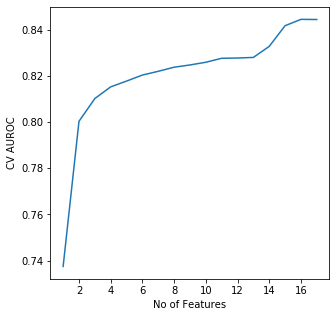

In [322]:
# RFE method
rfe = RFECV(estimator=LogisticRegression(), cv=4, scoring='roc_auc')
rfe = rfe.fit(train_x_upsampled, train_y_upsampled)
 
print('Number of features selected: {}'.format(rfe.n_features_))
print(rfe.grid_scores_)

# Plot number of features vs CV scores
plt.figure()
plt.xlabel('No of Features')
plt.ylabel('CV AUROC')
plt.plot(np.arange(1, rfe.grid_scores_.size+1), rfe.grid_scores_)
plt.show()

In [323]:
# Tree-based method
rf = RandomForestClassifier(n_jobs=-1, random_state=999)
rf.fit(train_x_upsampled, train_y_upsampled)
feat_imp = rf.feature_importances_

cols = train_x_upsampled.columns[feat_imp >= 0.01]
est_imp = LogisticRegression()
est_imp.fit(train_x_upsampled[cols], train_y_upsampled)
 
# Test AUC
print('Number of features selected: {}'.format(len(cols)))
test_y_prob_balanced = est_imp.predict_proba(test_x_upsampled)
test_y_prob_balanced = [p[1] for p in test_y_prob_balanced]
print('Balanced model AUROC: ' + str(roc_auc_score(test_y_upsampled, test_y_prob_balanced)))

feature_names = list(test_x_upsampled.columns.values)
feature_importances = list(rf.feature_importances_)
feature_list = []

for i in range(0,len(feature_names)):
    feature_list.append((feature_names[i], feature_importances[i]))
    
df_feature_select20 = pd.DataFrame(sorted(feature_list, reverse=True, key=lambda x: x[1])[:20])
df_feature_select20.columns = ['feature_select', 'feature_importance']
print(df_feature_select20)

Number of features selected: 17
Balanced model AUROC: 0.8493468213967559
             feature_select  feature_importance
0            MonthlyCharges            0.235642
1                    tenure            0.226211
2                  Contract            0.130215
3           InternetService            0.064520
4             PaymentMethod            0.062696
5                    gender            0.027287
6     OnlineSecurity_Binary            0.027125
7             MultipleLines            0.026881
8          PaperlessBilling            0.026071
9                   Partner            0.024961
10      OnlineBackup_Binary            0.024736
11       TechSupport_Binary            0.022875
12  DeviceProtection_Binary            0.020968
13               Dependents            0.020955
14   StreamingMovies_Binary            0.020405
15       StreamingTV_Binary            0.019260
16            SeniorCitizen            0.019193


It appears that the Tree-based algorithm gives a higher AUROC score, therefore we shall use Tree-based feature importance instead of RFE to select our features. Given that all the features have feature importance greater than 0.01, we will include all of them when improving model performance subsequently. 

### Obtaining the Best Model

To improve model performance, we shall fit multiple different models and obtain the one with the highest AUROC score. Before we fit the model, we will also convert the values of categorical variables using One Hot Encoding since the previous Label Encoding may cause some algorithms to misinterpret the values. In addition, we will apply Min Max Scaling to numeric variables as certain algorithms such as K-Nearest Neighbors are sensitive to magnitudes.

In [324]:
numeric_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])
numeric_features = train_x_upsampled.loc[:,['tenure','MonthlyCharges']].columns

categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder())])
categorical_features = train_x_upsampled.loc[:,['gender','SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines', 'InternetService', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'OnlineSecurity_Binary', 'OnlineBackup_Binary',
       'DeviceProtection_Binary', 'TechSupport_Binary', 'StreamingTV_Binary', 'StreamingMovies_Binary']].columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    NuSVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    LogisticRegression(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    XGBClassifier(random_state=1,learning_rate=0.05),
    lgb.LGBMClassifier(learning_rate = 0.15, metric = 'l1', n_estimators = 24),
    CatBoostClassifier()
    ]

for classifier in classifiers:
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', classifier)])
    pipe.fit(train_x_upsampled, train_y_upsampled)   
    print(classifier)
    
    # Get class probabilities for both models
    test_y_prob_balanced = pipe.predict_proba(test_x_upsampled)
 
    # We only need the probabilities for the positive class
    test_y_prob_balanced = [p[1] for p in test_y_prob_balanced]
 
    print('Balanced model AUROC: ' + str(roc_auc_score(test_y_upsampled, test_y_prob_balanced)))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')
Balanced model AUROC: 0.8574028901284835
SVC(C=0.025, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Balanced model AUROC: 0.8416760832003062
NuSVC(cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
      kernel='rbf', max_iter=-1, nu=0.5, probability=True, random_state=None,
      shrinking=True, tol=0.001, verbose=False)
Balanced model AUROC: 0.8512292313119175
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impu

81:	learn: 0.4615789	total: 4.31s	remaining: 48.3s
82:	learn: 0.4611412	total: 4.36s	remaining: 48.2s
83:	learn: 0.4606609	total: 4.41s	remaining: 48.1s
84:	learn: 0.4605803	total: 4.45s	remaining: 47.9s
85:	learn: 0.4603881	total: 4.49s	remaining: 47.7s
86:	learn: 0.4601937	total: 4.53s	remaining: 47.5s
87:	learn: 0.4596352	total: 4.58s	remaining: 47.5s
88:	learn: 0.4594705	total: 4.62s	remaining: 47.3s
89:	learn: 0.4592043	total: 4.67s	remaining: 47.2s
90:	learn: 0.4586809	total: 4.73s	remaining: 47.2s
91:	learn: 0.4582925	total: 4.78s	remaining: 47.2s
92:	learn: 0.4578227	total: 4.83s	remaining: 47.1s
93:	learn: 0.4572172	total: 4.88s	remaining: 47.1s
94:	learn: 0.4568355	total: 4.94s	remaining: 47.1s
95:	learn: 0.4565596	total: 4.99s	remaining: 47s
96:	learn: 0.4560590	total: 5.04s	remaining: 46.9s
97:	learn: 0.4557737	total: 5.09s	remaining: 46.8s
98:	learn: 0.4553780	total: 5.14s	remaining: 46.8s
99:	learn: 0.4548686	total: 5.19s	remaining: 46.8s
100:	learn: 0.4544888	total: 5.24

240:	learn: 0.4279167	total: 11.9s	remaining: 37.4s
241:	learn: 0.4276371	total: 11.9s	remaining: 37.4s
242:	learn: 0.4273010	total: 12s	remaining: 37.4s
243:	learn: 0.4270106	total: 12s	remaining: 37.3s
244:	learn: 0.4267166	total: 12.1s	remaining: 37.3s
245:	learn: 0.4266737	total: 12.2s	remaining: 37.2s
246:	learn: 0.4265925	total: 12.2s	remaining: 37.2s
247:	learn: 0.4265016	total: 12.2s	remaining: 37.1s
248:	learn: 0.4264203	total: 12.3s	remaining: 37.1s
249:	learn: 0.4263609	total: 12.3s	remaining: 37s
250:	learn: 0.4262801	total: 12.4s	remaining: 37s
251:	learn: 0.4260783	total: 12.5s	remaining: 37s
252:	learn: 0.4260775	total: 12.5s	remaining: 36.8s
253:	learn: 0.4259278	total: 12.5s	remaining: 36.8s
254:	learn: 0.4259256	total: 12.6s	remaining: 36.7s
255:	learn: 0.4258133	total: 12.6s	remaining: 36.6s
256:	learn: 0.4256755	total: 12.6s	remaining: 36.6s
257:	learn: 0.4255553	total: 12.7s	remaining: 36.5s
258:	learn: 0.4253652	total: 12.8s	remaining: 36.5s
259:	learn: 0.4251146	

399:	learn: 0.4155293	total: 19.1s	remaining: 28.6s
400:	learn: 0.4155291	total: 19.1s	remaining: 28.5s
401:	learn: 0.4155267	total: 19.1s	remaining: 28.4s
402:	learn: 0.4153991	total: 19.2s	remaining: 28.4s
403:	learn: 0.4153951	total: 19.2s	remaining: 28.3s
404:	learn: 0.4152530	total: 19.3s	remaining: 28.3s
405:	learn: 0.4152192	total: 19.3s	remaining: 28.2s
406:	learn: 0.4150795	total: 19.4s	remaining: 28.2s
407:	learn: 0.4150691	total: 19.4s	remaining: 28.2s
408:	learn: 0.4150663	total: 19.4s	remaining: 28.1s
409:	learn: 0.4149150	total: 19.5s	remaining: 28.1s
410:	learn: 0.4147882	total: 19.5s	remaining: 28s
411:	learn: 0.4147880	total: 19.6s	remaining: 27.9s
412:	learn: 0.4146656	total: 19.6s	remaining: 27.9s
413:	learn: 0.4146655	total: 19.6s	remaining: 27.8s
414:	learn: 0.4146635	total: 19.7s	remaining: 27.7s
415:	learn: 0.4146346	total: 19.7s	remaining: 27.7s
416:	learn: 0.4146329	total: 19.8s	remaining: 27.6s
417:	learn: 0.4145497	total: 19.8s	remaining: 27.6s
418:	learn: 0.

558:	learn: 0.4080269	total: 26.3s	remaining: 20.7s
559:	learn: 0.4080097	total: 26.3s	remaining: 20.7s
560:	learn: 0.4080073	total: 26.4s	remaining: 20.6s
561:	learn: 0.4080009	total: 26.4s	remaining: 20.6s
562:	learn: 0.4078853	total: 26.4s	remaining: 20.5s
563:	learn: 0.4078416	total: 26.5s	remaining: 20.5s
564:	learn: 0.4077425	total: 26.5s	remaining: 20.4s
565:	learn: 0.4077345	total: 26.6s	remaining: 20.4s
566:	learn: 0.4076552	total: 26.6s	remaining: 20.3s
567:	learn: 0.4076548	total: 26.7s	remaining: 20.3s
568:	learn: 0.4076526	total: 26.7s	remaining: 20.2s
569:	learn: 0.4076523	total: 26.8s	remaining: 20.2s
570:	learn: 0.4076515	total: 26.8s	remaining: 20.1s
571:	learn: 0.4076289	total: 26.8s	remaining: 20.1s
572:	learn: 0.4075823	total: 26.9s	remaining: 20s
573:	learn: 0.4075823	total: 26.9s	remaining: 20s
574:	learn: 0.4075109	total: 27s	remaining: 19.9s
575:	learn: 0.4073204	total: 27s	remaining: 19.9s
576:	learn: 0.4073002	total: 27.1s	remaining: 19.8s
577:	learn: 0.407297

717:	learn: 0.4026800	total: 33.4s	remaining: 13.1s
718:	learn: 0.4026793	total: 33.4s	remaining: 13.1s
719:	learn: 0.4026785	total: 33.4s	remaining: 13s
720:	learn: 0.4024957	total: 33.5s	remaining: 13s
721:	learn: 0.4024955	total: 33.5s	remaining: 12.9s
722:	learn: 0.4024734	total: 33.6s	remaining: 12.9s
723:	learn: 0.4024722	total: 33.6s	remaining: 12.8s
724:	learn: 0.4024718	total: 33.7s	remaining: 12.8s
725:	learn: 0.4024717	total: 33.7s	remaining: 12.7s
726:	learn: 0.4023231	total: 33.7s	remaining: 12.7s
727:	learn: 0.4022315	total: 33.8s	remaining: 12.6s
728:	learn: 0.4022099	total: 33.8s	remaining: 12.6s
729:	learn: 0.4022068	total: 33.9s	remaining: 12.5s
730:	learn: 0.4022068	total: 33.9s	remaining: 12.5s
731:	learn: 0.4022064	total: 33.9s	remaining: 12.4s
732:	learn: 0.4021496	total: 34s	remaining: 12.4s
733:	learn: 0.4021495	total: 34s	remaining: 12.3s
734:	learn: 0.4021493	total: 34s	remaining: 12.3s
735:	learn: 0.4019235	total: 34.1s	remaining: 12.2s
736:	learn: 0.4018984	

876:	learn: 0.3972970	total: 40.6s	remaining: 5.7s
877:	learn: 0.3972969	total: 40.7s	remaining: 5.65s
878:	learn: 0.3972277	total: 40.7s	remaining: 5.6s
879:	learn: 0.3972275	total: 40.7s	remaining: 5.56s
880:	learn: 0.3971855	total: 40.8s	remaining: 5.51s
881:	learn: 0.3971027	total: 40.8s	remaining: 5.46s
882:	learn: 0.3970852	total: 40.9s	remaining: 5.42s
883:	learn: 0.3970231	total: 40.9s	remaining: 5.37s
884:	learn: 0.3969555	total: 41s	remaining: 5.33s
885:	learn: 0.3968769	total: 41s	remaining: 5.28s
886:	learn: 0.3968494	total: 41.1s	remaining: 5.24s
887:	learn: 0.3968384	total: 41.1s	remaining: 5.19s
888:	learn: 0.3968378	total: 41.2s	remaining: 5.14s
889:	learn: 0.3968044	total: 41.2s	remaining: 5.1s
890:	learn: 0.3968037	total: 41.3s	remaining: 5.05s
891:	learn: 0.3968021	total: 41.3s	remaining: 5s
892:	learn: 0.3968019	total: 41.4s	remaining: 4.96s
893:	learn: 0.3968005	total: 41.4s	remaining: 4.91s
894:	learn: 0.3968002	total: 41.5s	remaining: 4.86s
895:	learn: 0.3967744	

We can observe that the Random Forest model has the highest AUROC score of 0.95. We shall then further improve its performance by tuning its hyperparameters.

### Hyperparameter Tuning for Best Model

In [325]:
#Hyperparameter tuning for most optimal model
finalpipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])   

params = {  
    'classifier__n_estimators': [100, 300, 500, 800, 1200],
    'classifier__max_depth': [5, 8, 15, 25, 30],
    'classifier__min_samples_leaf': [2, 5, 10, 15, 100],
    'classifier__min_samples_leaf': [1, 2, 5, 10]}

grid = GridSearchCV(finalpipe, param_grid=params, cv = 5, verbose = 1, n_jobs = -1, scoring='roc_auc')

grid.fit(train_x_upsampled, train_y_upsampled)

print("score = %3.2f" %(grid.score(test_x_upsampled,test_y_upsampled)))
print(grid.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  6.4min finished


score = 0.96
{'classifier__max_depth': 25, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 800}


Hyperparameter tuning helped improve AUROC score from 0.95 to 0.96.

We can now create a new RandomForestClassifier with the new best hyperparameters and identify the most important features.

### Most important features to focus on 

In [335]:
finalpipe2 = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(max_depth = 25, n_estimators = 800,  min_samples_leaf = 1))])  

finalpipe2.fit(train_x_upsampled, train_y_upsampled)   

test_y_prob_balanced = finalpipe2.predict_proba(test_x_upsampled)
test_y_prob_balanced = [p[1] for p in test_y_prob_balanced]
print('Balanced model AUROC: ' + str(roc_auc_score(test_y_upsampled, test_y_prob_balanced)))

Balanced model AUROC: 0.9642632085567892


In [363]:
featureimportanceSeries = pd.Series(finalpipe2.named_steps['classifier'].feature_importances_)

In [383]:
#order of the columns in transformed feature matrix follows the order of how columns are specified in the transformers list

featureSeries1 = pd.Series(["tenure","MonthlyCharges"])  #define manually since MinMaxScaler does not have get_feature_names
featureSeries2 = pd.Series(finalpipe2['preprocessor'].transformers_[1][1]['encoder'].get_feature_names(categorical_features))
featureSeriesfull = featureSeries1.append(featureSeries2)
featureSeriesfull = featureSeriesfull.reset_index(drop = True)

ImportantFeatures = pd.concat([featureSeriesfull, featureimportanceSeries], axis=1)
ImportantFeatures.columns = ['feature_select', 'feature_importance']
ImportantFeatures.sort_values(by = 'feature_importance', ascending = False).head(10)

,feature_select,feature_importance
0,tenure,0.186426
1,MonthlyCharges,0.184471
16,Contract_0.0,0.088635
18,Contract_2.0,0.039744
15,InternetService_2.0,0.037466
21,PaymentMethod_0.0,0.032755
17,Contract_1.0,0.018883
13,InternetService_0.0,0.017801
3,gender_1.0,0.017793
2,gender_0.0,0.017753


It appears that the top 5 features contributing to customer churn are tenure, MonthlyCharges, Contract, InternetService and PaymentMethod. We can do some deep dive analyses to understand customers' behaviour with respect to these five features to come up with solutions to reduce churn.

## Deep Dive Analyses on Most Important Features

For the deep dives, we can create visualizations of each feature with respect to Churn. For numeric variables (tenure, MonthlyCharges), we will employ the use of stacked bar and line charts to show the distribution. For categorical variables, we will use pie charts to show the split across categories.`

In [477]:
data2 = data.copy()

In [478]:
data2 = pd.get_dummies(data2, columns = ['Churn'])
data2.rename(columns={"Churn_0": "Non Churn", "Churn_1": "Churn"}, inplace = True)

Text(0.5, 0, 'tenure')

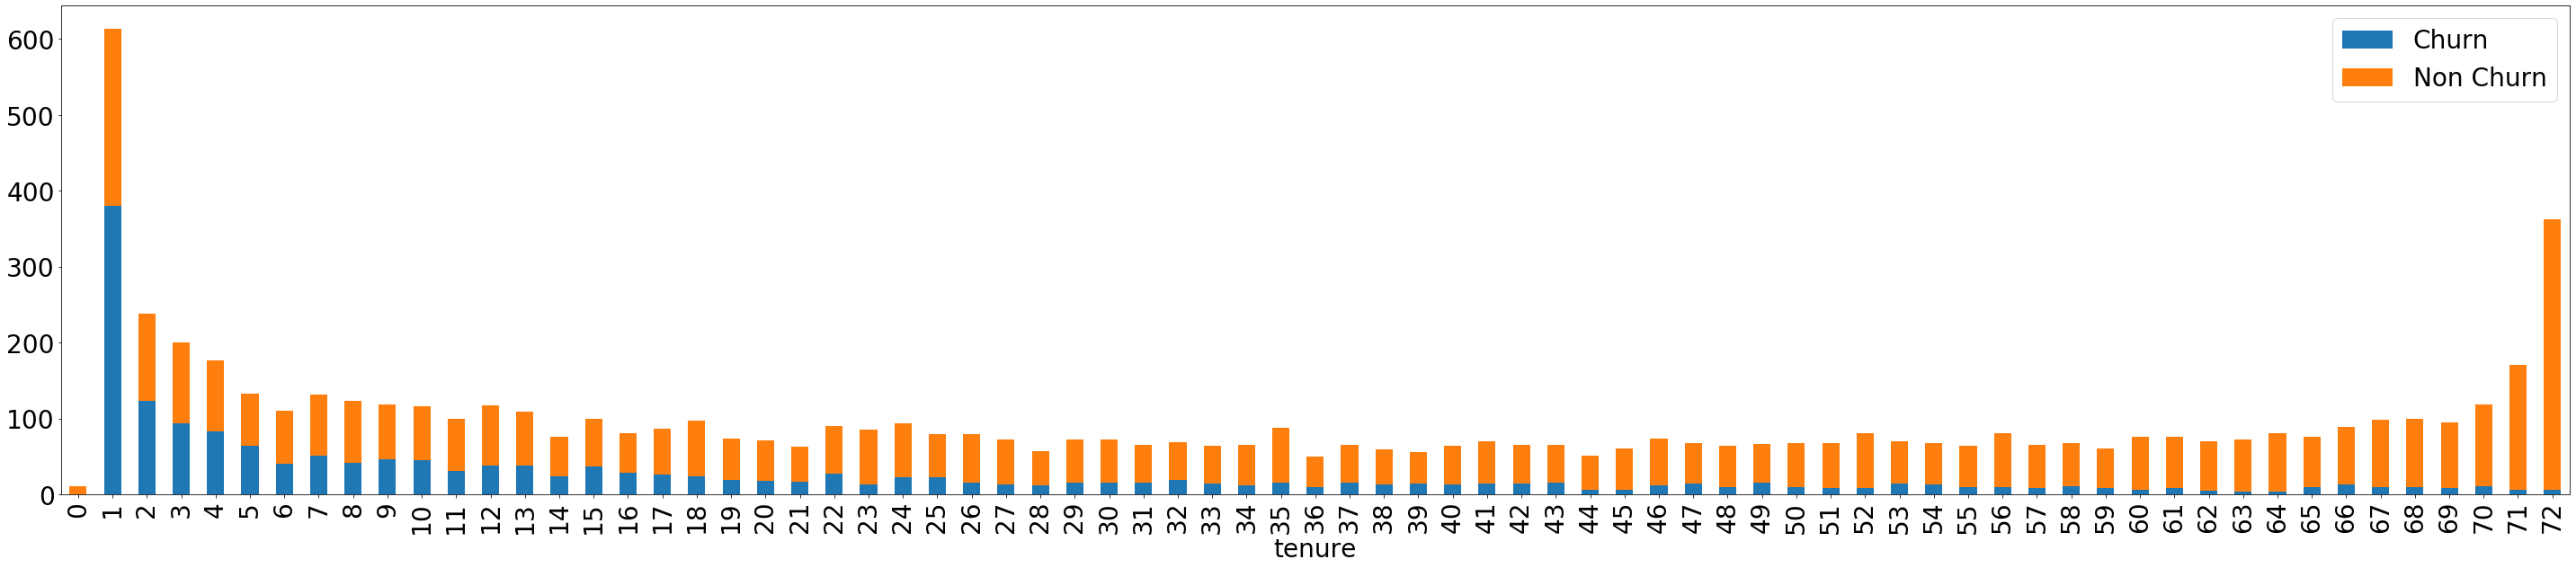

In [483]:
plt = data2.pivot_table(index = "tenure", values = ["Non Churn", "Churn"], aggfunc=sum).plot(kind = "bar", stacked = True, figsize=(50,10), fontsize = 28)
plt.legend(prop={'size': 28})
plt.set_xlabel('tenure',size = 28)

From the graph, we can observe that most people churn at the start of the tenure, especially after the first year. To overcome this problem, the company can come up with long term contracts such as 5 years to lock-in customers such that they are less likely to churn.

Text(0.5, 0, 'MonthlyCharges')

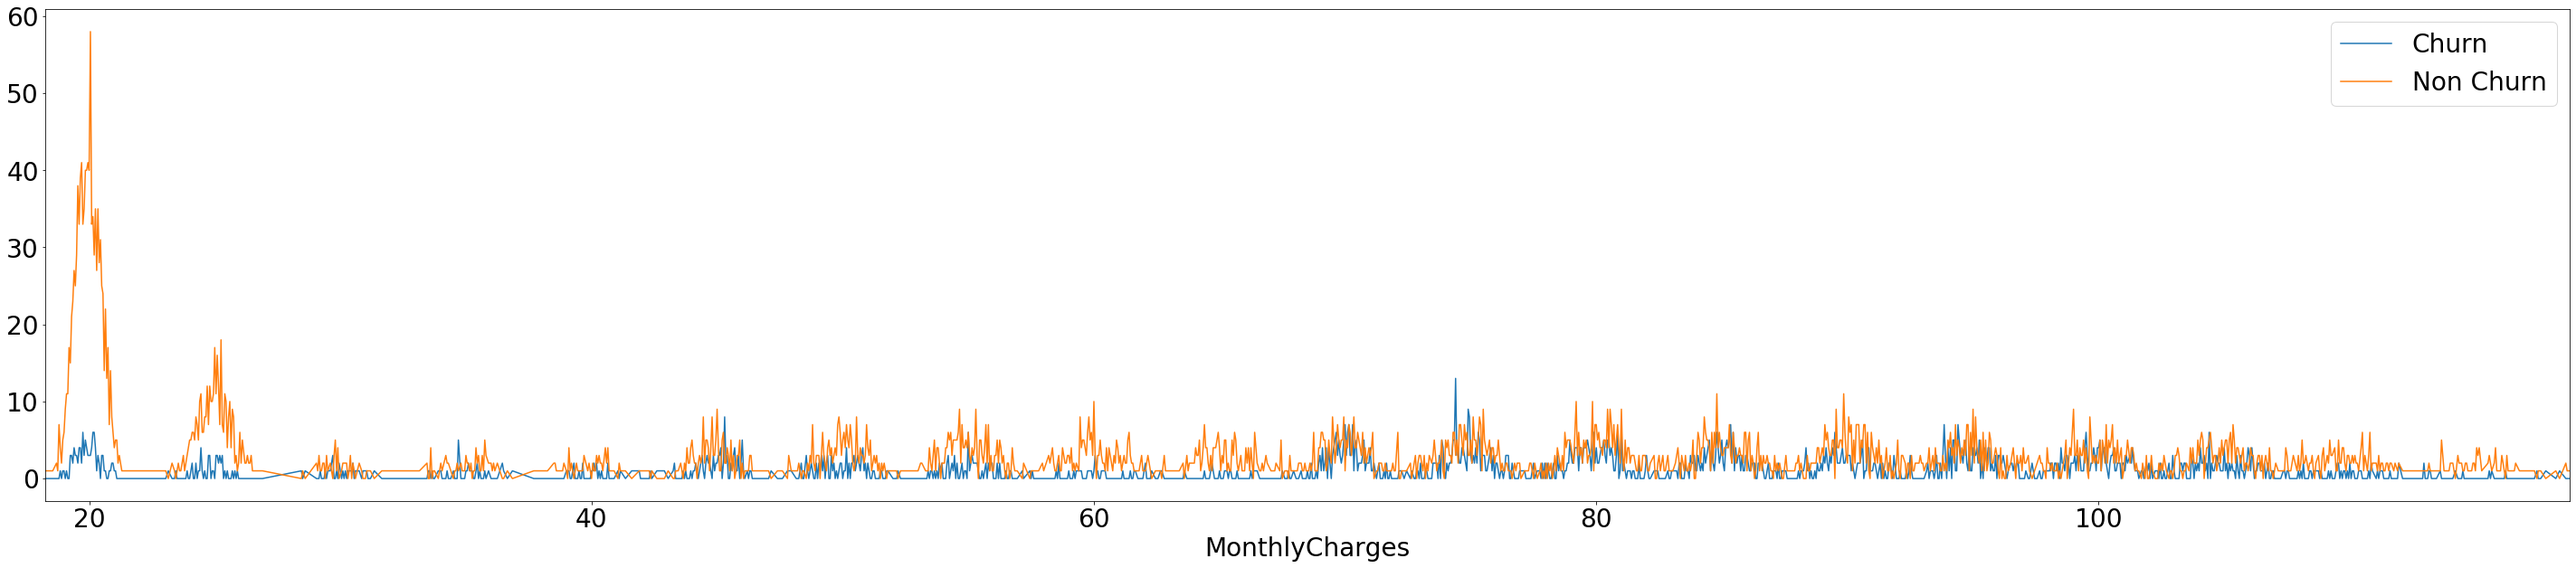

In [484]:
plt2 = data2.pivot_table(index = "MonthlyCharges", values = ["Non Churn", "Churn"], aggfunc=sum).plot(kind = "line", figsize=(50,10), fontsize = 28)
plt2.legend(prop={'size': 28})
plt2.set_xlabel('MonthlyCharges',size = 28)

For MonthlyCharges, we observe that churn remains relatively low across the range of monthly charges. What is striking however is that the number of people retained when monthly charge is around 20 or 25. As such, to better retain customers, the company should strive to keep monthly charge to 20 or 25.

In [531]:
data2.pivot_table(index = "Contract", values = ["Non Churn", "Churn"], aggfunc=sum)

,Churn,Non Churn
Contract,,
0,1655.0,2220.0
1,166.0,1307.0
2,48.0,1647.0


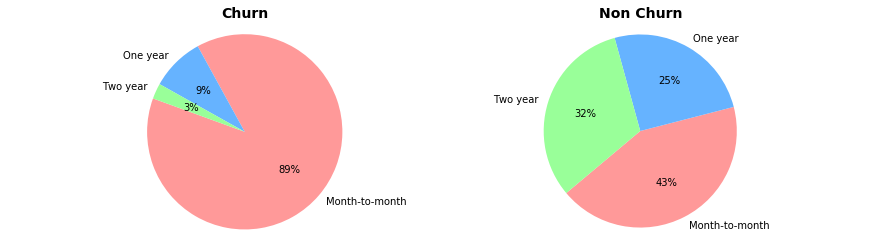

In [563]:
# Pie chart
labels = ['Month-to-month', 'One year', 'Two year']
sizes1 = [1655, 166, 48]
sizes2 = [2220, 1307, 1647]
#colors
colors = ['#ff9999','#66b3ff','#99ff99']
 
fig = plt.figure(figsize = (11,5))
ax1 = fig.add_axes([0, 0, .6, .6], aspect=1)
ax1.pie(sizes1, colors = colors, labels=labels, autopct='%1.0f%%', startangle=160)
ax2 = fig.add_axes([.5, .0, .6, .6], aspect=1)
ax2.pie(sizes2, colors = colors, labels=labels, autopct='%1.0f%%', startangle=220)

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
ax2.axis('equal')  
ax1.set_title('Churn', weight = "bold", fontsize = "14", color = "black")
ax2.set_title('Non Churn', weight = "bold", fontsize = "14", color = "black")
plt.show()

According to the Feature Importance table, month-to-month contract is significant in predicting churn. This corresponds with the pie chart above where we can see 89% of people who churned have month-to-month contracts. This is likely to be related to tenure too, since people who have month-to-month contracts probably have a shorter tenure compared to those who have longer contracts as they can switch easily. To remedy this, the company can remove or reduce their offerings of month-to-month contracts and give longer term contracts.

In [532]:
data2.pivot_table(index = "InternetService", values = ["Non Churn", "Churn"], aggfunc=sum)

,Churn,Non Churn
InternetService,,
0,113.0,1413.0
1,459.0,1962.0
2,1297.0,1799.0


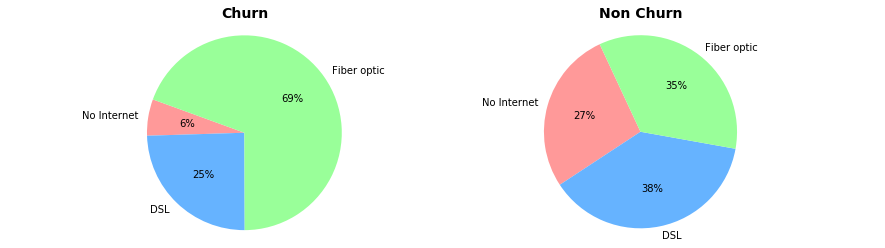

In [562]:
# Pie chart
labels = ['No Internet','DSL','Fiber optic']
sizes1 = [113, 459, 1297]
sizes2 = [1413, 1962, 1799]
#colors
colors = ['#ff9999','#66b3ff','#99ff99']
 
fig = plt.figure(figsize = (11,5))
ax1 = fig.add_axes([0, 0, .6, .6], aspect=1)
ax1.pie(sizes1, colors = colors, labels=labels, autopct='%1.0f%%', startangle=160)
ax2 = fig.add_axes([.5, .0, .6, .6], aspect=1)
ax2.pie(sizes2, colors = colors, labels=labels, autopct='%1.0f%%', startangle=115)

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
ax2.axis('equal')  
ax1.set_title('Churn', weight = "bold", fontsize = "14", color = "black")
ax2.set_title('Non Churn', weight = "bold", fontsize = "14", color = "black")
plt.show()

Similarly, for InternetService, fiber optic is most significant in predicting churn and is represented in the pie chart with 69% of customers who churned using fiber optic. This suggests that perhaps customers are not very happy using the company's existing fiber optic product and churn, switching to other alternatives. The company should do an investigation and get feedback on why people aren't using their fiber optic product anymore, perhaps through interviews or a survey.

In [549]:
data2.pivot_table(index = "PaymentMethod", values = ["Non Churn", "Churn"], aggfunc=sum)

,Churn,Non Churn
PaymentMethod,,
0,1071.0,1294.0
1,308.0,1304.0
2,258.0,1286.0
3,232.0,1290.0


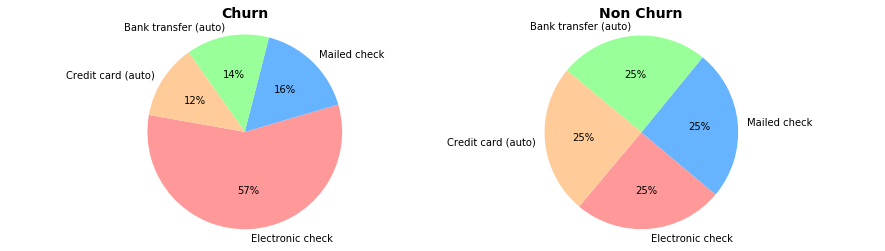

In [568]:
# Pie chart
labels = ['Electronic check', 'Mailed check', 'Bank transfer (auto)','Credit card (auto)']
sizes1 = [1071, 308, 258, 232]
sizes2 = [1294, 1304, 1286, 1290]
#colors
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
 
fig = plt.figure(figsize = (11,5))
ax1 = fig.add_axes([0, 0, .6, .6], aspect=1)
ax1.pie(sizes1, colors = colors, labels=labels, autopct='%1.0f%%', startangle=170)
ax2 = fig.add_axes([.5, .0, .6, .6], aspect=1)
ax2.pie(sizes2, colors = colors, labels=labels, autopct='%1.0f%%', startangle=230)

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
ax2.axis('equal')  
ax1.set_title('Churn', weight = "bold", fontsize = "14", color = "black")
ax2.set_title('Non Churn', weight = "bold", fontsize = "14", color = "black")
plt.show()

Last but not least, for payment method, Electronic check is most significant in predicting churn and 57% of people who churned were using Electronic check to pay. This suggests that perhaps Electronic check may be a very cumbersome and inconvenient method for customers to pay, especially when the charges come in monthly. The company should look into their existing electronic check payment system and see if they can expedite the process. 